# used-car-price-us-canada

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="used-car-price-us-canada")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/joaopedrosdmm/used-car-price-us-canada


'https://jovian.ai/joaopedrosdmm/used-car-price-us-canada'

In [5]:
# install and import the libraries
!pip install opendatasets pandas numpy matplotlib seaborn tqdm sklearn  --quiet
!pip install xgboost==1.2.1 -U --quiet # THIS VERSION IS NECESSARY FOR COMPATIBILITY ISSUES
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import pickle # to save the results
from tqdm.notebook import tqdm
import opendatasets as od
from sklearn.metrics import mean_squared_error
import os
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
import xgboost
print(xgboost.__version__) # !!! important : must be 1.2.1, if not restart kernel.

     |████████████████████████████████| 148.9 MB 91 kB/s 
1.2.1


### 1- Download and clean up data

In [6]:
dataset_url = 'https://www.kaggle.com/rupeshraundal/marketcheck-automotive-data-us-canada?select=us-dealers-used.csv'

In [7]:
%%time
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: inkasaras
Your Kaggle Key: ··········


100%|██████████| 420M/420M [00:08<00:00, 52.4MB/s]

CPU times: user 9.95 s, sys: 2.14 s, total: 12.1 s
Wall time: 2min


In [8]:
data_dir = './marketcheck-automotive-data-us-canada/us-dealers-used.csv'

### View Dataset Files

In [9]:
# List of files with size
!ls -lh {data_dir}

-rw-r--r-- 1 root root 1.2G Jun  2 16:12 ./marketcheck-automotive-data-us-canada/us-dealers-used.csv


### Loading Training Set

In [10]:
import random
sample_frac = 0.1

In [11]:
selected_cols = "vin,price,miles,year,make,model,body_type,drivetrain,fuel_type,engine_size,state".split(",")
print(selected_cols)

['vin', 'price', 'miles', 'year', 'make', 'model', 'body_type', 'drivetrain', 'fuel_type', 'engine_size', 'state']


In [12]:
def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

In [13]:
random.seed(42)

In [14]:
df = pd.read_csv(data_dir, 
                 usecols=selected_cols, 
                 skiprows=skip_row)

We choose to drop all the rows missing pieces of information since we have a enought data.

In [15]:
df.isna().sum()

vin                0
price          65931
miles           6688
year              16
make               0
model            820
body_type       2829
drivetrain      1643
fuel_type       4653
engine_size    10609
state           1166
dtype: int64

In [16]:
df.dropna(inplace=True)

*   Find out if there are any duplicated Vin 
*   Remove the duplicated Vin rows.
*   And, then remove the Vin collum, since it doesn't help out our model





In [17]:
df.drop_duplicates('vin', inplace=True)

In [18]:
df.drop("vin",axis = 1, inplace=True)

Some errors found on the State, some are misspelled.




In [19]:
df.state.unique()

array(['FL', 'MI', 'MO', 'AR', 'AZ', 'CO', 'NJ', 'VA', 'TX', 'GA', 'ID',
       'AL', 'IA', 'CA', 'PA', 'WA', 'TN', 'OR', 'NC', 'DE', 'KS', 'HI',
       'OH', 'WV', 'NY', 'UT', 'ND', 'IL', 'MA', 'WY', 'IN', 'NV', 'MD',
       'SC', 'NE', 'VT', 'KY', 'WI', 'NH', 'CT', 'OK', 'RI', 'MN', 'MS',
       'MT', 'SD', 'LA', 'NM', 'ME', 'PR', 'AK', 'GU', 'BC', 'MP', 'ON',
       'QC', 'DC'], dtype=object)

In [20]:
# get all the unique values in the 'Country' column
state = df.state.unique()

# sort them alphabetically and then take a closer look
state.sort()
state

array(['AK', 'AL', 'AR', 'AZ', 'BC', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'ON', 'OR', 'PA', 'PR',
       'QC', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY'], dtype=object)

We have the year of the model, but we want the age of the car

In [21]:
df["age"] = 2022 - df["year"]

In [22]:
df.drop("year",axis = 1, inplace=True)

We'll use the following ranges:

*   price: 500 to 100000 dollar
*   age: 1 to 25 years old
*   miles: 5000 to 200000

In [23]:
def remove_outliers(df):
    return df[(df['price'] >= 500) & 
              (df['price'] <= 100000) & 
              (df['age'] >= 1.) & 
              (df['age'] <= 25.) &
              (df['miles'] >= 5000) & 
              (df['miles'] <= 200000)]

In [24]:
df = remove_outliers(df)

In [25]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/joaopedrosdmm/used-car-price-us-canada


'https://jovian.ai/joaopedrosdmm/used-car-price-us-canada'

### 2- Exploratory Data Analysis

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421126 entries, 0 to 711254
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        421126 non-null  float64
 1   miles        421126 non-null  float64
 2   make         421126 non-null  object 
 3   model        421126 non-null  object 
 4   body_type    421126 non-null  object 
 5   drivetrain   421126 non-null  object 
 6   fuel_type    421126 non-null  object 
 7   engine_size  421126 non-null  float64
 8   state        421126 non-null  object 
 9   age          421126 non-null  float64
dtypes: float64(4), object(6)
memory usage: 35.3+ MB


In [27]:
df.head()

,price,miles,make,model,body_type,drivetrain,fuel_type,engine_size,state,age
0,27921.0,7339.0,BMW,i3,Hatchback,RWD,Electric / Premium Unleaded,0.6,FL,4.0
1,6500.0,74274.0,Chevrolet,HHR,Mini Mpv,FWD,E85 / Unleaded,2.2,MI,12.0
2,23024.0,131286.0,Chevrolet,Colorado,Pickup,RWD,Diesel,2.8,MO,6.0
3,16995.0,110615.0,Mercedes-Benz,CLS-Class,Coupe,RWD,Premium Unleaded,5.5,AR,11.0
5,16888.0,35001.0,Chevrolet,Colorado,Pickup,RWD,Unleaded,2.9,AZ,10.0


In [28]:
df.describe()

,price,miles,engine_size,age
count,421126.000000,421126.000000,421126.000000,421126.000000
mean,26030.000779,56345.490917,3.099111,5.660090
std,13796.506827,40866.791728,1.330147,3.400627
min,888.000000,5000.000000,0.600000,1.000000
25%,16395.000000,25628.000000,2.000000,4.000000
50%,23147.500000,42900.000000,2.500000,4.000000
75%,33449.000000,79981.000000,3.600000,7.000000
max,99999.000000,200000.000000,8.300000,25.000000


Ask & Answer Questions(example)

Ask & answer questions about the dataset:

* What is the busiest day of the week?
* What is the busiest time of the day?
* In which month are fares the highest?
* Which pickup locations have the highest fares?
* Which drop locations have the highest fares?
* What is the average ride distance?

EDA + asking questions will help you develop a deeper understand of the data and give you ideas for feature engineering. 

The first scatterplot shows the relationship between mileage, age and price of used cars.

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


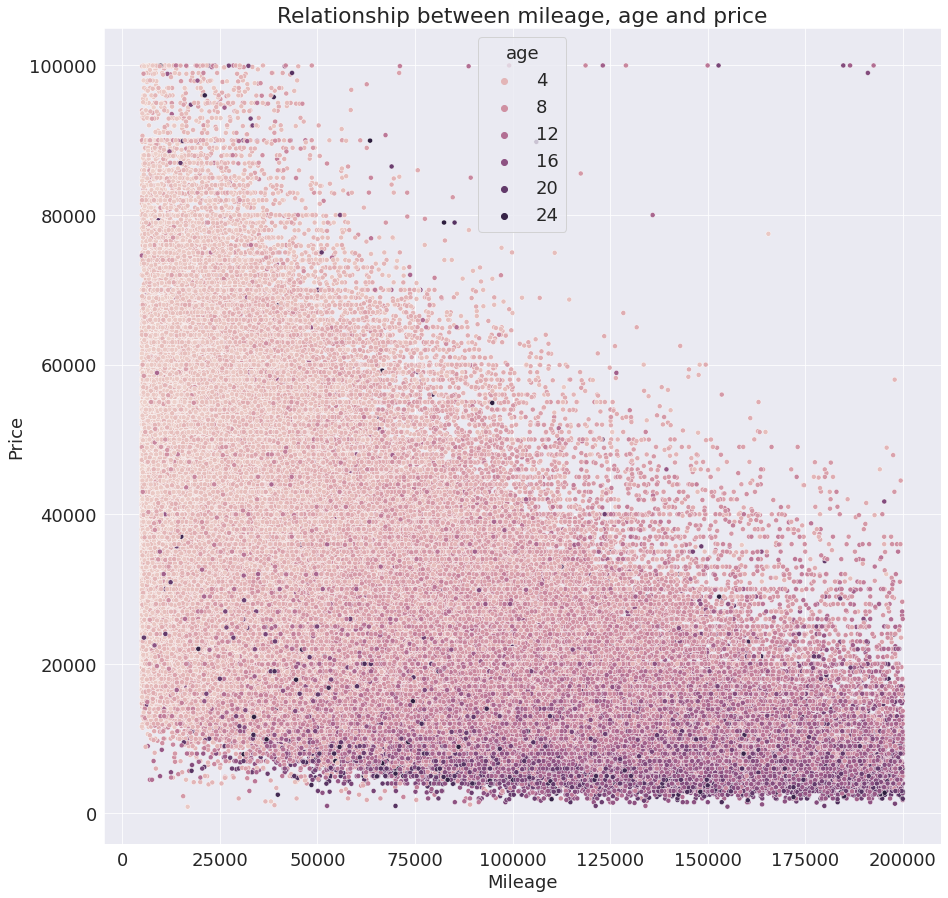

In [29]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
fig = sns.scatterplot(y ='price', x='miles', hue = 'age', data=df, s=25);
fig.set(xlabel = 'Mileage', ylabel = 'Price', title = 'Relationship between mileage, age and price');

The next graphs show the most and the least expensive car makes in the market.

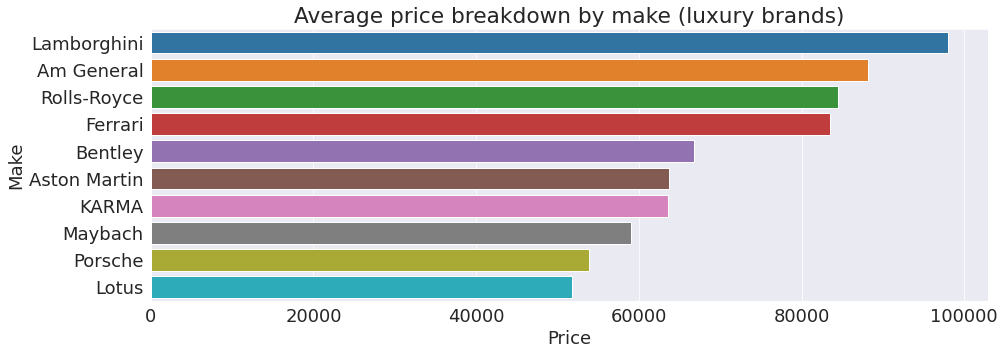

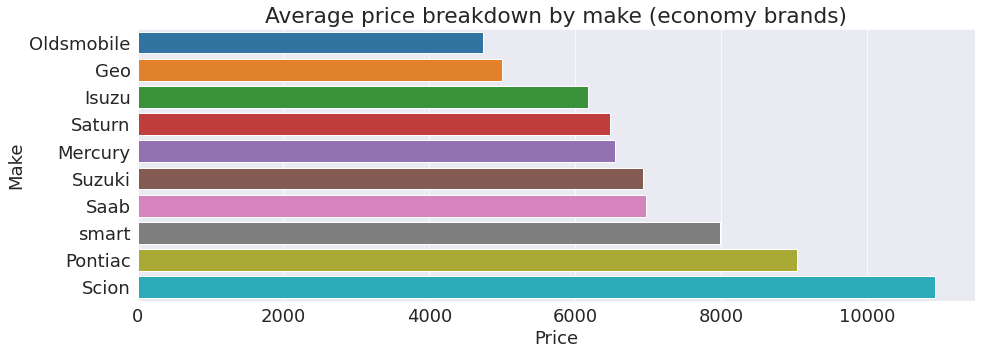

In [30]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  df.groupby(column)['price'].mean().sort_values(ascending=False).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (luxury brands)');
plt.figure()
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  df.groupby(column)['price'].mean().sort_values(ascending=True).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (economy brands)');

Let's explore which drivetrain is more common in US.

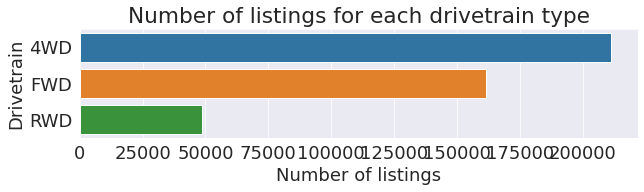

In [31]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'drivetrain'
graph =  df.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Drivetrain', title = 'Number of listings for each drivetrain type');

Next the ratio of Body types in the US market.

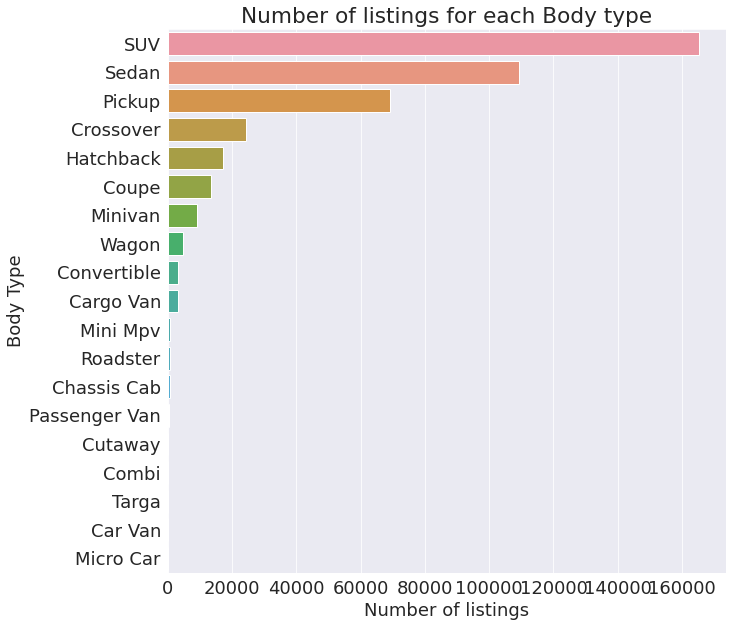

In [32]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
column = 'body_type'
graph =  df.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Body Type', title = 'Number of listings for each Body type');

In some states, used vehicles are more expensive due to the cost of living, taxes, and emission control. This is shown in the next graph.

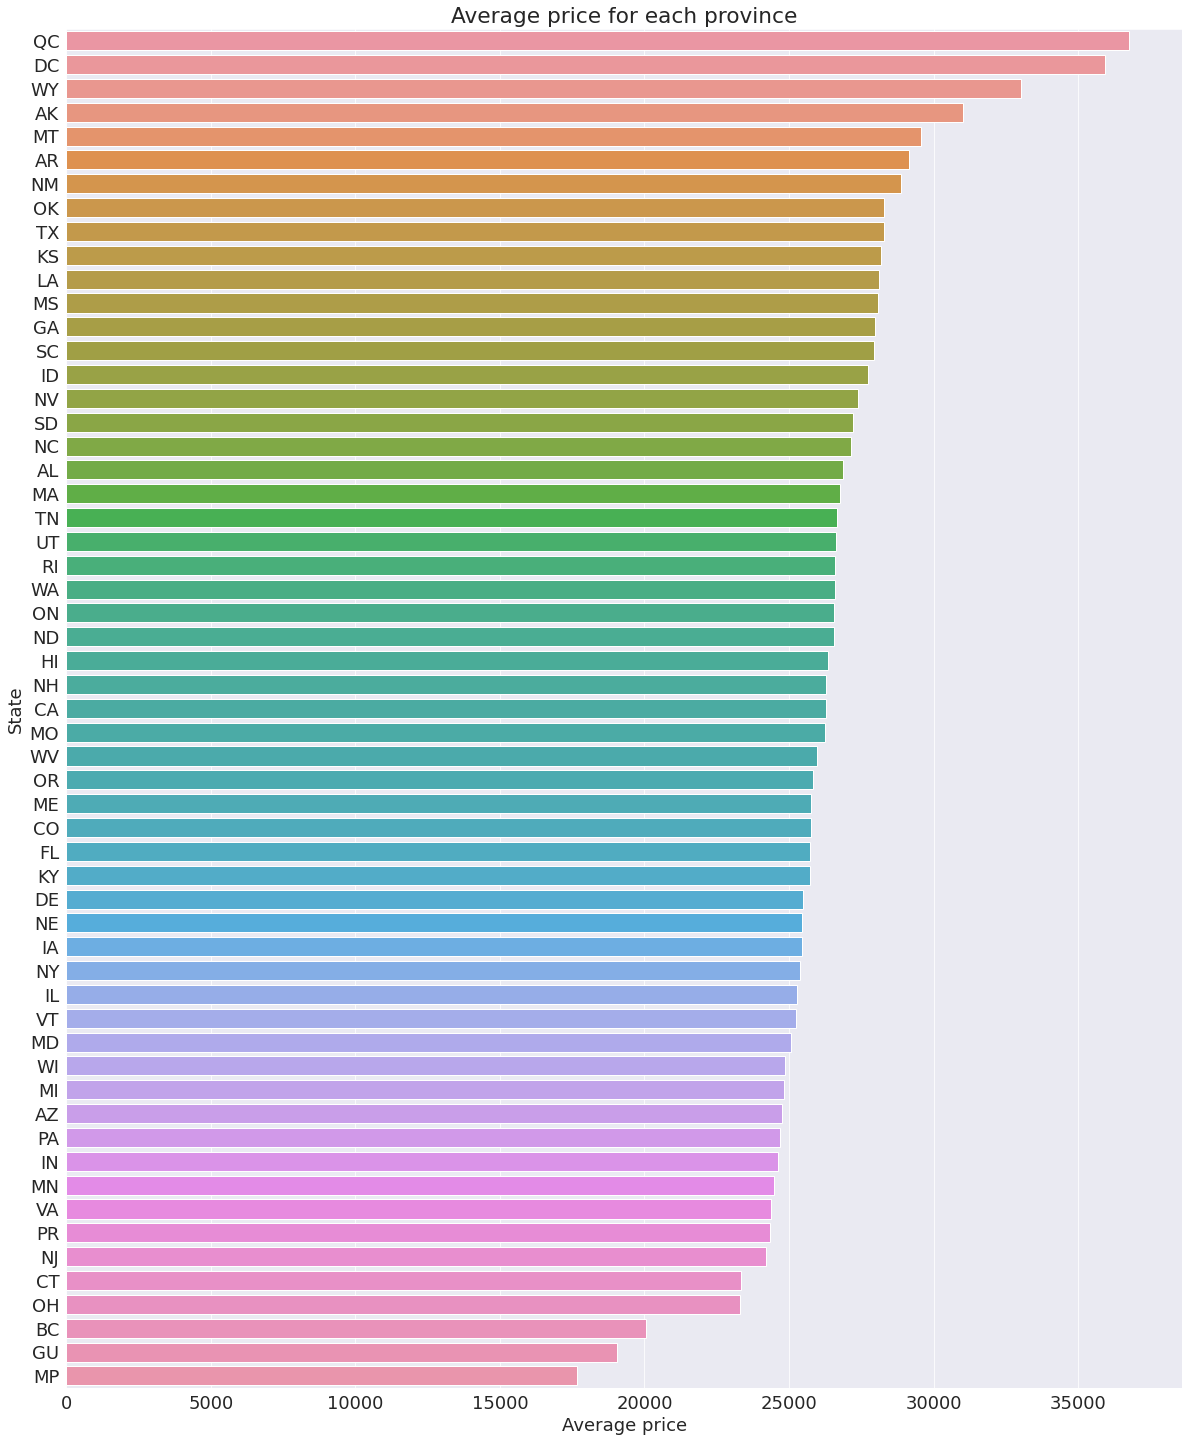

In [33]:
matplotlib.rcParams['figure.figsize'] = (20,25)
column = 'state'
graph =  df.groupby(column)['price'].mean().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Average price', ylabel = 'State', title = 'Average price for each province');

The market share of each province is directly related to its population size. 

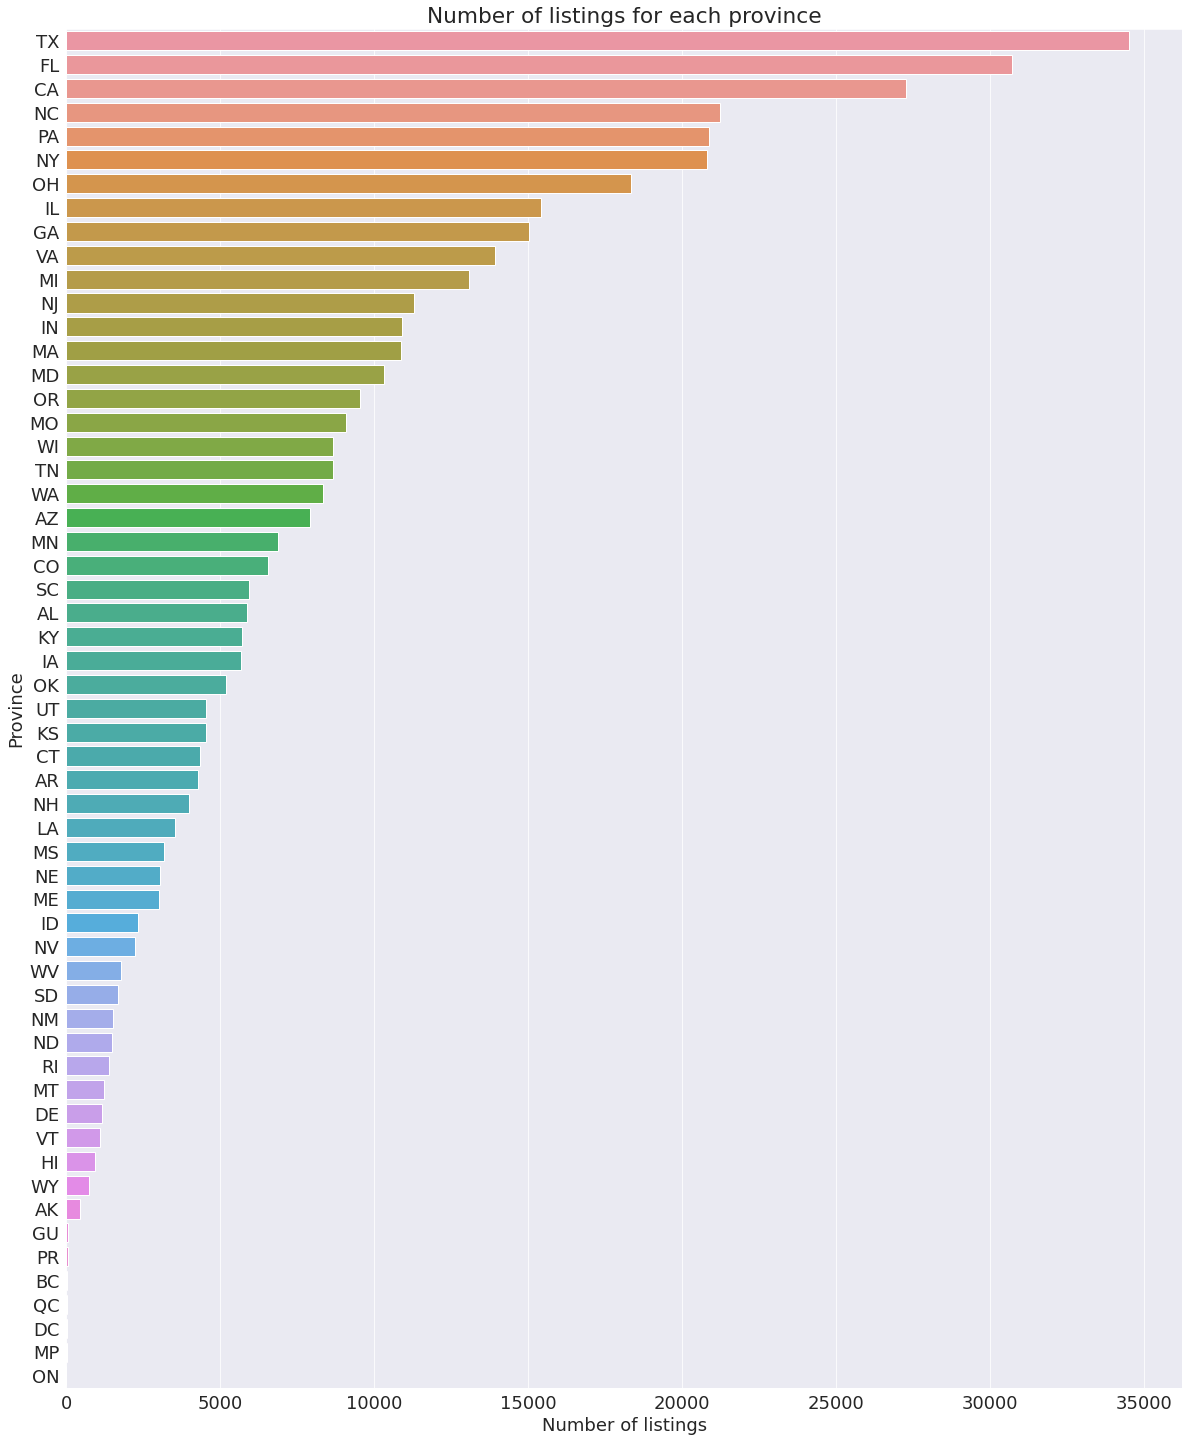

In [34]:
matplotlib.rcParams['figure.figsize'] = (20, 25)
column = 'state'
graph =  df.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Province', title = 'Number of listings for each province');

In [35]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/joaopedrosdmm/used-car-price-us-canada


'https://jovian.ai/joaopedrosdmm/used-car-price-us-canada'

### 3 - Prepare data for machine learning

Selecting the most suitable features to predict/evaluate a used car price.

In [36]:
# Target column
target = ["price"]

# Numerical columns in df 
features_num = ["miles", "age", 'engine_size']

# Categorical columns in df
features_cat =  [col for col in df.columns if df[col].dtype == "object"]

#To be more accurate I should have name features_num and features_cat as num_cols and cat_cols

# We could use  df.select_dtypes(include=['object'] to select all categoricals
# Or  df.select_dtypes(exclude=['object']) to drop all object  

In [37]:
df.columns

Index(['price', 'miles', 'make', 'model', 'body_type', 'drivetrain',
       'fuel_type', 'engine_size', 'state', 'age'],
      dtype='object')

In [38]:
avg_price = df["price"].mean()

Split the data into training, validation and testing sets.

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [41]:
#Test Input and Output
X_test = test_df[features_num + features_cat]
y_test = test_df[target]

##Train and Validation, Input and Output
X_train_val = train_val_df[features_num + features_cat]
y_train_val = train_val_df[target]

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

The numerical features will be scaled using scikit learn minmax scaler.

In [43]:
# Normalize numeric inputs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[features_num])
X_train[features_num] = scaler.transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])
X_valid[features_num] = scaler.transform(X_valid[features_num])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


**Investigating cardinality for categorical data.**

We refer to the number of unique entries of a categorical variable as the cardinality of that categorical variable.

In [44]:
# Get number of unique entries in each column with categorical data
features_cat_nunique = list(map(lambda col: X_train[col].nunique(), features_cat))
d = dict(zip(features_cat, features_cat_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('drivetrain', 3),
 ('body_type', 19),
 ('fuel_type', 30),
 ('make', 55),
 ('state', 57),
 ('model', 826)]

We'll only apply a one-hot encoding for columns with cardinality less than 10. 

We do this because one-hot encoding adds lots of collums to our model, making it slow. Example: if we had 50 nun-unique values for the feature "make" and 153505 rows of data, we would end up with: 153505*50 - 153505 collumns.

In [45]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in features_cat if  X_train[col].nunique() <= 10]

# Columns that will be ordinal encoded
high_cardinality_cols = list(set(features_cat)-set(low_cardinality_cols))

print('Categorical columns that will be one-hot encoded:', low_cardinality_cols)
print('\nCategorical columns that will be ordinal encoded:', high_cardinality_cols)

Categorical columns that will be one-hot encoded: ['drivetrain']

Categorical columns that will be ordinal encoded: ['fuel_type', 'model', 'body_type', 'state', 'make']


**One-hot encoding** for categorical features with **low cardinality**.



In [46]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))
OH_cols_test =  pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
OH_cols_test.index = X_test.index

**Ordinal encoding** for categorical features with **high cardinality**.




In [47]:
# Columns that can be safely ordinal encoded
good_label_cols = [col for col in high_cardinality_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(high_cardinality_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['body_type', 'state']

Categorical columns that will be dropped from the dataset: ['make', 'fuel_type', 'model']


Fitting an ordinal encoder to a column in the training data creates a corresponding integer-valued label for each unique value that appears in the training data. In the case that the validation data contains values that don't also appear in the training data, the encoder will throw an error, because these values won't have an integer assigned to them. 

For instance, imagine that we have in the validation data the "make" "Fiat", but this "make" does't appear in the training data -- thus, if we try to use an ordinal encoder with scikit-learn, the code will throw an error.

This is a common problem that we encounter with real-world data, and there are many approaches to fixing this issue. For instance, we can write a custom ordinal encoder to deal with new categories. The simplest approach, however, is to drop the problematic categorical columns (bad_label_cols).

However, our aproach to fix this problem is as easy as droping the problematic columms. We use handle_unknown in the Ordinal Encoder from scikit learn. We then define a value for unknown_value and we are good to go.


In [48]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train[high_cardinality_cols].copy()
label_X_valid = X_valid[high_cardinality_cols].copy()
label_X_test = X_test[high_cardinality_cols].copy()

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
label_X_train[high_cardinality_cols] = ordinal_encoder.fit_transform(X_train[high_cardinality_cols])
label_X_valid[high_cardinality_cols] = ordinal_encoder.transform(X_valid[high_cardinality_cols])
label_X_test[high_cardinality_cols] = ordinal_encoder.transform(X_test[high_cardinality_cols])

We will add one-hot encoded columns and ordinal encoded columns to numerical features

In [49]:
N_X_train = pd.concat([X_train[features_num], OH_cols_train, label_X_train], axis=1)
N_X_valid = pd.concat([X_valid[features_num], OH_cols_valid, label_X_valid], axis=1)
N_X_test = pd.concat([X_test[features_num], OH_cols_test, label_X_test], axis=1)

In [50]:
N_X_train.head()

,miles,age,engine_size,0,1,2,fuel_type,model,body_type,state,make
134490,0.140769,0.125000,0.376623,1.0,0.0,0.0,10.0,254.0,15.0,42.0,15.0
258964,0.486605,0.250000,0.233766,0.0,1.0,0.0,25.0,385.0,16.0,11.0,27.0
71899,0.502015,0.625000,0.155844,0.0,1.0,0.0,25.0,171.0,5.0,41.0,19.0
83867,0.154933,0.291667,0.233766,0.0,1.0,0.0,25.0,64.0,16.0,21.0,19.0
72570,0.163364,0.208333,0.155844,0.0,1.0,0.0,25.0,638.0,16.0,37.0,39.0


In [51]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/joaopedrosdmm/used-car-price-us-canada


'https://jovian.ai/joaopedrosdmm/used-car-price-us-canada'

### 4 - Predicting the price using machine learning 


We will train and tune various machine learning regression algorithms. The first method is based on gradient boosting, using the library **XGBoost**.

Make Predictions and Submit to Kaggle

Let's define a helper function to evaluate models and generate test predictions

In [52]:
def evaluate(model):
    train_preds = model.predict(N_X_train)
    train_rmse = mean_squared_error(y_train, train_preds, squared=False)
    val_preds = model.predict(N_X_valid)
    val_rmse = mean_squared_error(y_valid, val_preds, squared=False)
    test_preds = model.predict(N_X_test)
    test_rmse = mean_squared_error(y_test, test_preds, squared=False)
    return train_rmse, val_rmse, test_rmse, train_preds, val_preds, test_preds

 **Regression using XGBoost**

XGBoost has multiple hyperparameters.We will tune only two parameters:

*   max_depth: Maximum depth of a tree. A tree's depth is a measure of how many splits it makes before coming to a prediction. You can capture more factors using a tree that has more "splits". These are called "deeper" trees. Increasing this value will make the model more complex and more likely to overfit.
* n_estimators: Number of trees. A high number of trees will most likely lead to overfitting.

We will use a grid search method to find the optimal values of these hyperparameters.

In [53]:
# import XGBoost 
from xgboost import XGBRegressor 

In [54]:
model = XGBRegressor(objective='reg:squarederror', 
                     n_jobs=-1, 
                     random_state=42, 
                     n_estimators=500, 
                     max_depth=7, 
                     learning_rate=0.1, 
                     subsample=0.8, 
                     colsample_bytree=0.8)

In [55]:
%%time
model.fit(N_X_train, y_train)

CPU times: user 1min 44s, sys: 201 ms, total: 1min 44s
Wall time: 1min 45s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
train_rmse, val_rmse, test_rmse, train_preds, val_preds, test_preds = evaluate(model)

In [57]:
print('Percentage validation error={:.2f}%'.format(100*val_rmse/avg_price))
print('Percentage test error={:.2f}%'.format(100*test_rmse/avg_price))

Percentage validation error=12.66%
Percentage test error=13.09%


In [58]:
model.save_model('XGB.txt')

In [59]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/joaopedrosdmm/used-car-price-us-canada


'https://jovian.ai/joaopedrosdmm/used-car-price-us-canada'

### 6 - Tune Hyperparmeters

In [60]:
def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(N_X_train, y_train)
    train_rmse = mean_squared_error(model.predict(N_X_train), y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(N_X_valid), y_valid, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [61]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

### No. of Trees

CPU times: user 6min 17s, sys: 714 ms, total: 6min 18s
Wall time: 6min 16s


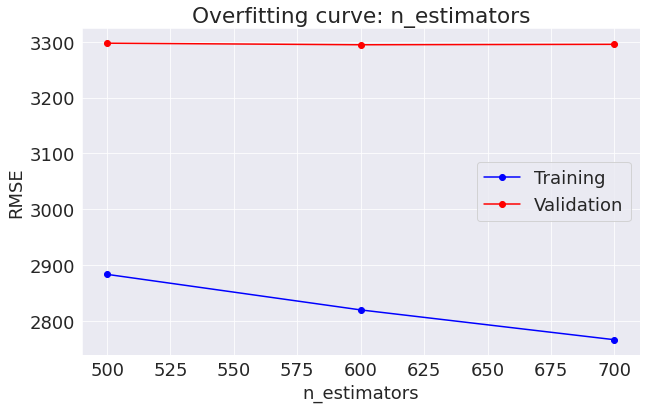

In [62]:
%%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [ 500, 600 ,700], **best_params)

Seems like 500 estimators has the lowest validation loss. However, it also takes a long time.

In [63]:
best_params['n_estimators'] = 500

### Max Depth

CPU times: user 6min 28s, sys: 779 ms, total: 6min 28s
Wall time: 6min 35s


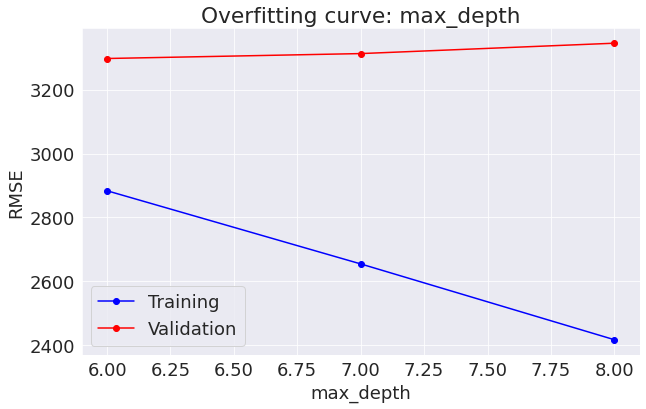

In [64]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', [6, 7, 8 ], **best_params)

Looks like a max depth of 7 is ideal.

In [65]:
best_params['max_depth'] = 7

### Learning Rate

CPU times: user 6min 36s, sys: 749 ms, total: 6min 37s
Wall time: 6min 40s


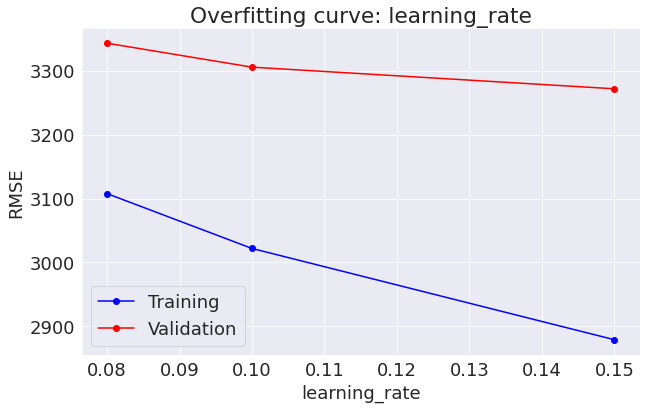

In [66]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [ 0.08, 0.1, 0.15], **best_params)

Seems like the best learning rate is 0.1

In [67]:
best_params['learning_rate'] = 0.1

### Final Model

In [68]:
model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=750, max_depth=7, learning_rate=0.1, 
                               subsample=0.8, colsample_bytree=0.8)

In [69]:
%%time
model_final.fit(N_X_train, y_train)

CPU times: user 2min 35s, sys: 268 ms, total: 2min 35s
Wall time: 2min 34s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
train_rmse_final, val_rmse_final, test_rmse_final, train_preds_final, val_preds_final, test_preds_final = evaluate(model_final)

In [ ]:
print('Percentage validation error={:.2f}%'.format(100*val_rmse_final/avg_price))
print('Percentage test error={:.2f}%'.format(100*test_rmse_final/avg_price))

In [ ]:
model.save_model('XGB_final.txt')

Let's test our prediction algorithm on a sample. This data comes from an actual transaction. This sample transaction was not reported in the dataset. 

In [ ]:
#price, miles, make, model,	body_type,	drivetrain,	fuel_type,	engine_size, state	age
my_car = [25000.0, 17000/1.6,'FIAT','124 Spider','Convertible','RWD',"Unleaded",1.4,'NY', 4.0]
sample = pd.DataFrame(columns=df.columns)
sample.loc[0] = my_car

sample[features_num] = scaler.transform(sample[features_num])
OH_cols_sample = pd.DataFrame(OH_encoder.transform(sample[low_cardinality_cols]))
OH_cols_sample.index = sample.index
sample[high_cardinality_cols] = ordinal_encoder.transform(sample[high_cardinality_cols])

sample_inputs = pd.concat([sample[features_num], OH_cols_sample, sample[high_cardinality_cols]], axis=1)

#sample_inputs = pd.concat([X_train[features_num], OH_cols_train, label_X_train], axis=1)
sample_output = sample[target]
sample_prediction = model_final.predict(sample_inputs)
print("listing price={:.2f}  /  predicted price={:.2f}".format(sample_output.values[0][0],sample_prediction[0]))

I would say it is very close to the correct price.


In [ ]:
jovian.commit(files=['XGB.txt','XGB_final.txt'])

In [ ]:
jovian.commit()